<a href="https://colab.research.google.com/github/AamirKhaan/Student-Academic-Performance/blob/master/10_Multinomial_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="background-color:Aqua; padding:20px; border-radius:10px">Multinomial Logistic Regression</h1>

## Overview      

<div style="background-color:Gainsboro; padding:20px; text-align:justify; font-weight: bold">
    <p>In this section following steps are performed: </p>
    <ol>
        <li>Data Preparation and Encoding</li>
        <li>Preliminary Multinomial Logistic Regression (MLR)</li>
        <li>Multinomial Ligistic Regression Optimization with Inverse Regularization Strength</li>
        <li>Multinomial Ligistic Regression with optimized Inverse Regularization Strength</li>
        <li>Repeated Stratified k-Fold Cross Validation</li>
        <li>Model Learning Curve</li>
    </ol>
</div>


### Standard Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

In [2]:
# Jupyter Noteboook Configurations (personal prefrences)
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_columns', None)
sns.set() 

In [3]:
# Global parameters for figure
plt.rcParams["figure.figsize"] = [10.00, 8.00]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.autolayout"] = True

### 1. Data Preparation and Encoding

#### 1.1 Import Modified Data

In [4]:
# Import the Student's data from local storage
# ! Dont' run the cell in colab
data_df = pd.read_csv('./data/xAPI-Edu-Data_modified.csv')

In [5]:
# Import the Student's data from github storage
# Run only in colab
url = 'https://raw.githubusercontent.com/AamirKhaan/Student-Academic-Performance/main/data/xAPI-Edu-Data_modified.csv'
data_df = pd.read_csv(url)

In [6]:
# Selected Features
CATEGORICAL_FEATURES = ['stage_id','relation', 'parent_answering_survey', 
                            'parent_school_satisfaction','student_absence_days']
NUMERICAL_FEATURES = ['raised_hands', 'visited_resources', 'announcements_view', 'discussion']
TARGET = ['class']

In [7]:
# Optimize Data Type for efficent memory utilization
for feature in CATEGORICAL_FEATURES:
    data_df[feature] = data_df[feature].astype('category')
    
for feature in NUMERICAL_FEATURES:
    data_df[feature] = data_df[feature].astype('int8')

data_df[TARGET] = data_df[TARGET].astype('category')

#### 1.2 Encode Data

In [8]:
# Input Features Encoding
categorical_encoder = OrdinalEncoder(dtype='int8')
categorical_ds  = categorical_encoder.fit_transform(data_df[CATEGORICAL_FEATURES])
categorical_encoded = pd.DataFrame(categorical_ds, columns=CATEGORICAL_FEATURES, dtype='int8')
# Target Encoding
target_encoder = LabelEncoder()
target_ds = target_encoder.fit_transform(data_df[TARGET])
target_encoded = pd.DataFrame(target_ds, columns=TARGET, dtype='int8')
# Combine the Data
encoded_df = pd.concat([categorical_encoded,data_df[NUMERICAL_FEATURES]], axis=1)

### 2.  Preliminary Multinomial Logistic Regression (MLR)

In [9]:
X = encoded_df
y = target_encoded

In [10]:
# Test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [11]:
# Gaussian Naive Bayes
clf = LogisticRegression(multi_class='multinomial', solver='lbfgs')

#### 2.1 Model Parameters

In [12]:
# Model parameters
clf.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'multinomial',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [13]:
# Train the model
clf = clf.fit(X_train, y_train)

#### 2.3 Model Scores

In [14]:
# Test Accuracy
y_hat = clf.predict(X_test)
initial_test_accuracy = accuracy_score(y_test, y_hat)
print(f'Preliminary MLR Test Accuracy: {initial_test_accuracy*100}')
# Train Accuracy
predictions_train = clf.predict(X_train)
initial_train_accuracy = accuracy_score(y_train, predictions_train)
print(f'Preliminary MLR Train Accuracy: {initial_train_accuracy*100}')

Preliminary MLR Test Accuracy: 70.88607594936708
Preliminary MLR Train Accuracy: 72.5


<div style="background-color:Gainsboro; padding:20px; text-align:justify; ">
<p>The accuracy of the model on Training Data (72.5%) is close to the accuracy on Test Data (70./89%), show a resonabiliy skilled model. </p>
</div>

#### 2.4 Confusion Matrix

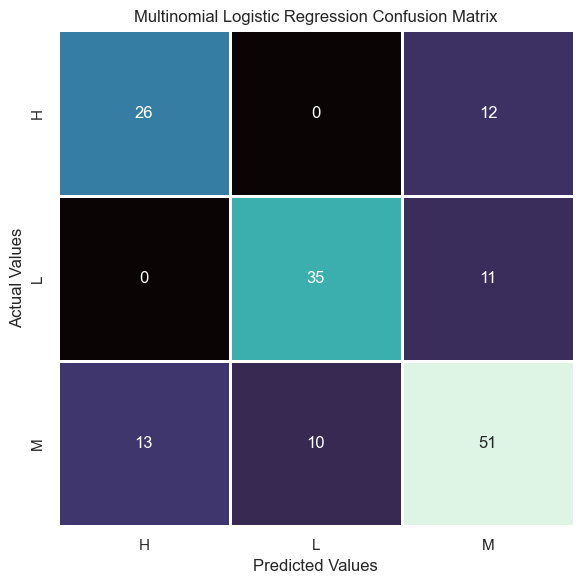

In [17]:
cm_df = pd.DataFrame(confusion_matrix(y_test, y_hat),
                     index = ['H','L','M'], 
                     columns = ['H','L','M'])

fig = plt.figure(figsize=(6,6))
sns.heatmap(cm_df, annot=True, cmap='mako',cbar=False,linewidth=1)
plt.title('Multinomial Logistic Regression Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

#### 2.5 Classification Report

In [16]:
print('Multinomial Logistic Regression Report\n')
print(classification_report(y_test,y_hat, target_names=['H','L','M']))

Multinomial Logistic Regression Report

              precision    recall  f1-score   support

           H       0.67      0.68      0.68        38
           L       0.78      0.76      0.77        46
           M       0.69      0.69      0.69        74

    accuracy                           0.71       158
   macro avg       0.71      0.71      0.71       158
weighted avg       0.71      0.71      0.71       158



### 3. Multinomial Ligistic Regression Optimization with Inverse Regularization Strength

<div style="background-color:Gainsboro; padding:20px; text-align:justify;">
<p>Based on the knowledge from the preliminary MLR model. The possibility of increasing the model accuracy can be further investigated by varying the weights of the coefficients of the penalty, which can be set via the “C” argument.(Inverse of regularization strength).</p>
<p></p>
<b>C close to 1.0:</b> Light penalty.</br>
<b>C close to 0.0:</b> Strong penalty. 
</div>

In [18]:
C_values = np.logspace(-5,0,num=50,endpoint=True)
clf_rls = []
for p in C_values :
    if p == 0.0:
        clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='none')
    else:
         clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='l2', C=p)
    clf.fit(X_train, y_train)
    clf_rls.append(clf)

train_scores = [clf.score(X_train,y_train) for clf in clf_rls]
test_scores = [clf.score(X_test,y_test) for clf in clf_rls]

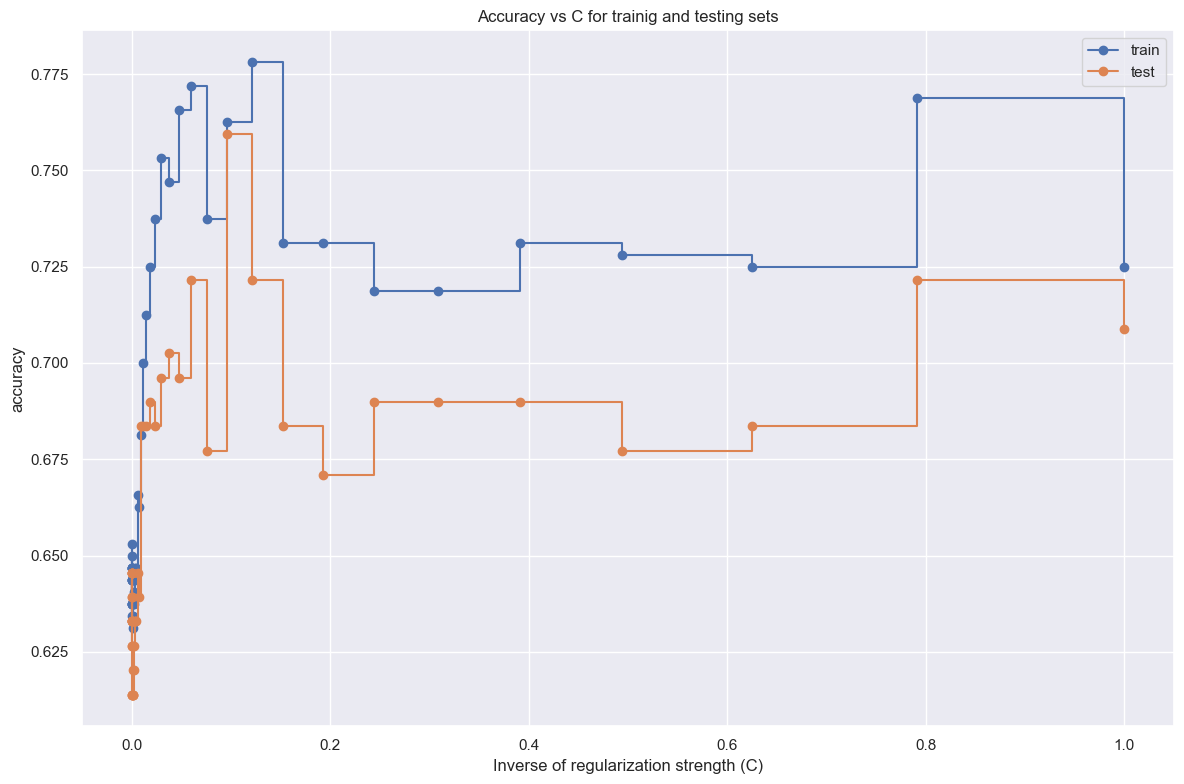

In [19]:
plt.rcParams["figure.figsize"] = [12.00, 8.00]
fig, ax = plt.subplots()
ax.set_xlabel('Inverse of regularization strength (C)')
ax.set_ylabel('accuracy')
ax.set_title('Accuracy vs C for trainig and testing sets')
ax.plot(C_values , train_scores, marker='o', label='train', drawstyle='steps-post')
ax.plot(C_values , test_scores, marker='o', label='test', drawstyle='steps-post')
ax.legend()
plt.show()

<div style="background-color:Gainsboro; padding:20px; text-align:justify;">
<p>The graph of accuracy vs C show the variation in the accuracy with respect to C values in Training and Test data.</p>
</div>

In [20]:
# Get the index of the peak accuracy on the test data
index_max = test_scores.index(max(test_scores))

### 4. Multinomial Ligistic Regression with optimized Inverse Regularization Strength

#### 4.1 Optimized MLR Parameters

In [21]:
clf_rls[index_max].get_params()

{'C': 0.09540954763499944,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'multinomial',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

#### 4.2 Optimized MLR Scores

In [23]:
# Test Accuracy
opt_y_test = clf_rls[index_max].predict(X_test)
opt_test_accuracy = accuracy_score(y_test, opt_y_test)
print(f'Optimized MLR Test Accuracy: {opt_test_accuracy*100}')
# Train Accuracy
opt_y_train = clf_rls[index_max].predict(X_train)
opt_train_accuracy = accuracy_score(y_train, opt_y_train)
print(f'Optimized MLR  Train Accuracy: {opt_train_accuracy*100}')

Optimized MLR Test Accuracy: 75.9493670886076
Optimized MLR  Train Accuracy: 76.25


<div style="background-color:Gainsboro; padding:20px; text-align:justify; ">
<p>The accuracy of the optimized model on Training Data (76.25%) is slightly greater than the accuracy on Test Data (75.95%). The model shows acceptable performance. </p>
</div>

#### 4.3 Optimized MLR Confusion Matrix

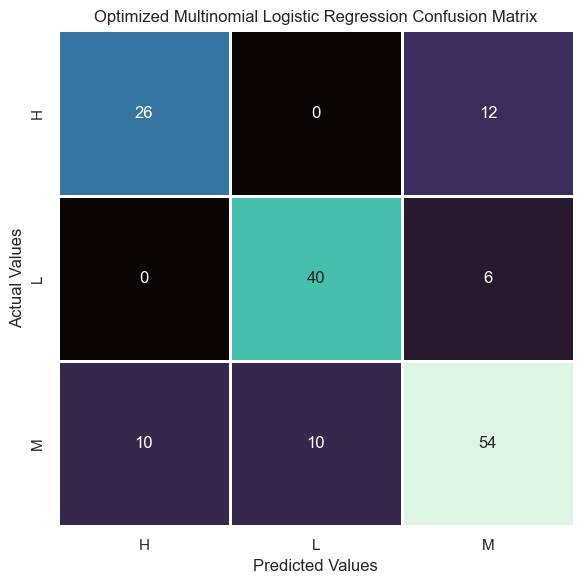

In [24]:
ocm_df = pd.DataFrame(confusion_matrix(y_test, opt_y_test),
                     index = ['H','L','M'], 
                     columns = ['H','L','M'])

fig = plt.figure(figsize=(6,6))
sns.heatmap(ocm_df, annot=True, cmap='mako',cbar=False,linewidth=1)
plt.title('Optimized Multinomial Logistic Regression Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

#### 4.4 Optimized MLR Classification report

In [25]:
print('Optimized Multinomial Logistic Regression Report\n')
print(classification_report(y_test,opt_y_test, target_names=['H','L','M']))

Optimized Multinomial Logistic Regression Report

              precision    recall  f1-score   support

           H       0.72      0.68      0.70        38
           L       0.80      0.87      0.83        46
           M       0.75      0.73      0.74        74

    accuracy                           0.76       158
   macro avg       0.76      0.76      0.76       158
weighted avg       0.76      0.76      0.76       158



### 5. Repeated Stratified k-Fold Cross Validation

In [26]:
# Model
clf_cv = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='l2', C=0.095409547)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

scores = cross_val_score(clf_cv, X_train, y_train, scoring='accuracy', cv = cv, n_jobs=-1)

# Performance
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean Accuracy: 0.715 (0.070)


### 6. Model Learning Curve

In [27]:
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=42)
estimator = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='l2', C=0.095409547)

train_sizes=np.linspace(0.1, 1.0, 5)

train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=-1,
        train_sizes=train_sizes,
        return_times=True,
    )

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

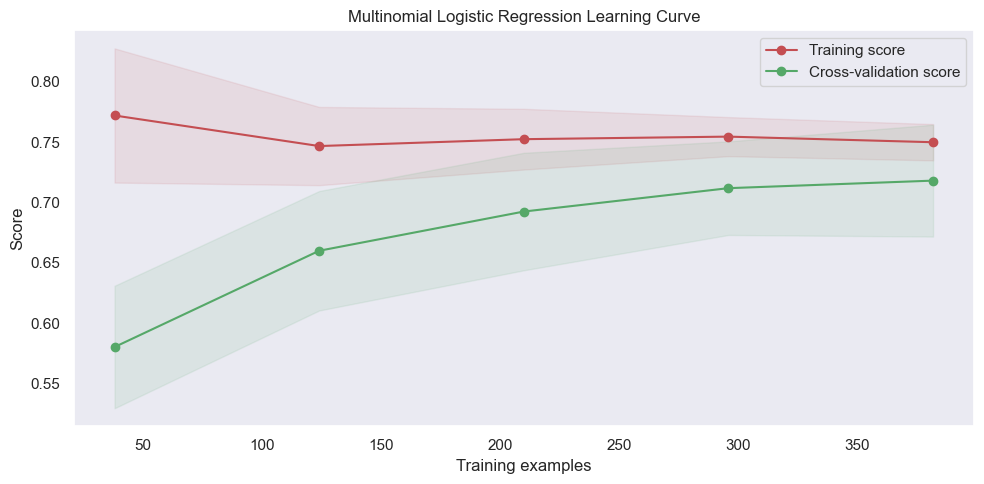

In [28]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title('Multinomial Logistic Regression Learning Curve')
ax.set_xlabel("Training examples")
ax.set_ylabel("Score")
# Plot learning curve
ax.grid()
ax.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",)

ax.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",)
    
ax.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")   
ax.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score")   
ax.legend(loc="best");

## Observations
  
The key observations are:  
   
1. The Preliminary Multinomial Logoistic Regressor has:     
    a. Test Accuracy of 70.88%     
    b. Train Accuracy of 72.5%     
2. Optimization usign Inverse of regularization strenght, C of approximately 0.08541 results in highest accuracy of 75.95%.
3. The Optimized Multinomial Logistic Regressor has:   
    a. Test Accuracy of 75.95%     
    b. Train Accuracy of 76.25%    
4. The 10 Fold Cross Validation fo the Base Decision Tree relusted in Mean Accuracy of 71.5%.

## Conclusion
Based on the obervations:

1. The Optimized Multinomial Logistic Regressor produced the maximum test accuracy of 75.95%.
2. The Cross Validation produced mean accuracy of 71.5% that show the model quite well trained and generalized over the given data.